In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2024-05-16 13:53:54'

In [2]:
import mysql.connector
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.ticker as ticker

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',

    })


plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")
from cycler import cycler

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.7
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rc("axes", prop_cycle=standard_cycler)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


In [346]:
import matplotlib as mpl
from matplotlib.colors import to_hex
import matplotlib.colors as mcolors
import math
from utils.qgaussian_utils import MultivariateBetaGaussianDiag, HeavyTailedBetaGaussian


def policy_evolution(policy, num_samples, colormapname, fig, ax, name, normalize=True):
    cmap = mpl.colormaps[colormapname]
    color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]
    
    dfs = []
    plot_xs = []
    plot_ys = []
    plot_gys = []
    xs = torch.FloatTensor(np.linspace(-1, 1, num=num_samples).reshape((num_samples, 1)))
    x = np.linspace(-1, 1, num=num_samples)
    curve_id = 0
    for idx, info in enumerate(policy[:50]):
        #if idx == 49:
        #    pass
        if idx % 10 != 0 or idx == 0:
            continue
        mean, shape = info[0].item(), info[1]
        dist = None
        if name == "Gaussian":
            dist = torch.distributions.Normal(mean, shape.exp().item())
            print(f'{name} : {mean} +- {shape.exp().item()}')
        elif name == "Heavy-tailed Gaussian":
            dist = HeavyTailedBetaGaussian(torch.FloatTensor([mean]), torch.FloatTensor([shape.item()]), entropic_index=2)
            print(f'{name} : {mean} +- {shape.item()}')

        elif name == "Q-Gaussian":
            dist = MultivariateBetaGaussianDiag(torch.FloatTensor([mean]), torch.FloatTensor([shape.item()]), alpha=2)
            print(f'{name} : {mean} +- {shape.item()}')

        d = torch.exp(dist.log_prob(xs)).detach().cpu().numpy()
        if normalize:
            density = (d - np.min(d)) / (np.max(d) - np.min(d))
        else:
            density = d
            
        if curve_id in [1,3]:
            linestyle='--'
        else:
            linestyle='-'
        curve_id += 1
        ax.plot(xs.flatten(), density.flatten(), zs=idx, zdir='y', color=color_list[min(60+idx*4, 254)], alpha=1, linewidth=1, linestyle=linestyle)
    ax.plot([], [], c=color_list[150], linestyle='-', label=name, alpha=1)


Gaussian : 0.3283127546310425 +- 0.47104665637016296
Gaussian : 0.5286974906921387 +- 0.6000697612762451
Gaussian : -0.3324022889137268 +- 1.1595357656478882
Gaussian : -0.9999138116836548 +- 0.0009999999310821295
Q-Gaussian : 0.13074934482574463 +- 0.9999989867210388
Q-Gaussian : 0.36823010444641113 +- 0.9999989867210388
Q-Gaussian : -0.968792736530304 +- 0.9999989867210388
Q-Gaussian : 0.6314818859100342 +- 0.9999989867210388
Heavy-tailed Gaussian : -0.6535704731941223 +- 0.07926029711961746
Heavy-tailed Gaussian : -0.6910303235054016 +- 0.04168405383825302
Heavy-tailed Gaussian : -0.8951247334480286 +- 0.005908144637942314
Heavy-tailed Gaussian : -0.3874187469482422 +- 0.08853756636381149
ax.azim -60
ax.elev 30


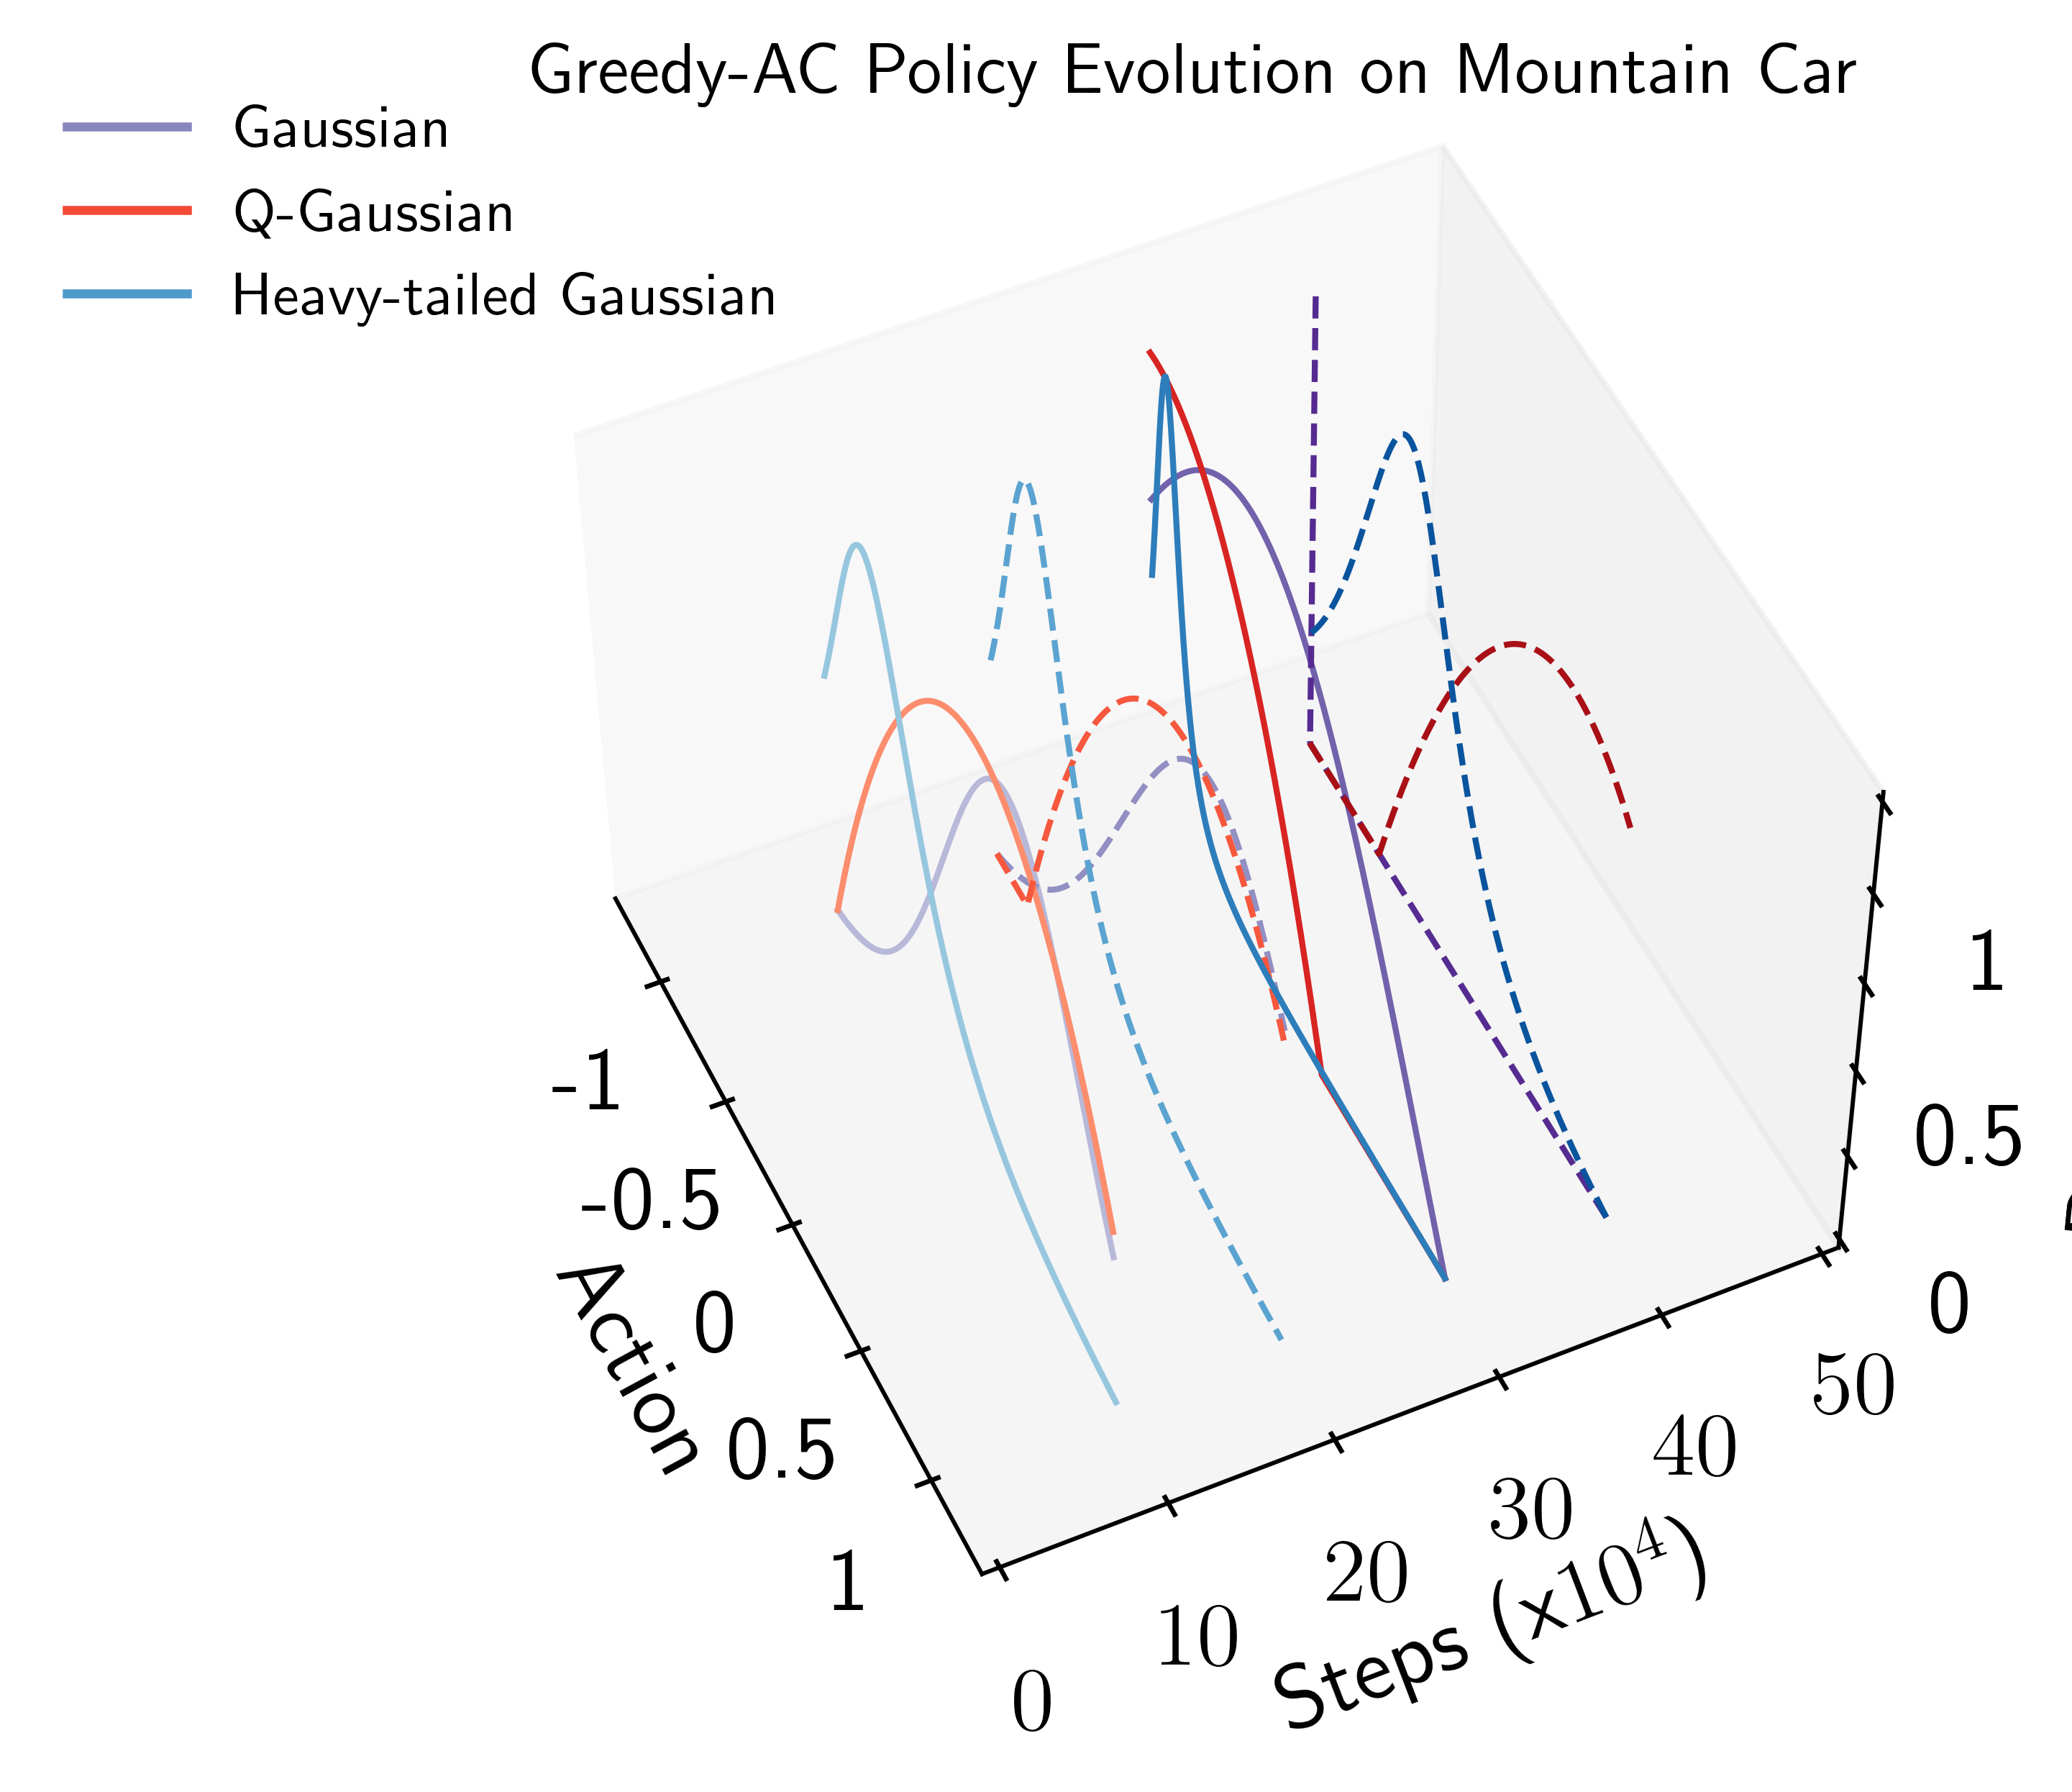

In [357]:
fig, ax = plt.subplots(1, 1, figsize=(7.2, 4.45), dpi=600, subplot_kw={'projection': '3d'})
plt.title("Greedy-AC Policy Evolution on Mountain Car", fontsize=12)

policy_evolution(torch.load('../saved_policies/gaussian.pt'), 2000, "Purples", fig, ax, "Gaussian")
policy_evolution(torch.load('../saved_policies/q_gaussian.pt'), 2000, "Reds", fig, ax, "Q-Gaussian")
policy_evolution(torch.load('../saved_policies/heavytailed_gaussian.pt'), 2000, "Blues", fig, ax, "Heavy-tailed Gaussian")

print('ax.azim {}'.format(ax.azim))
print('ax.elev {}'.format(ax.elev))

ax.view_init(50, -25)
xticks = [-1, -0.5, 0, 0.5, 1]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=0)
#ax.set_zlim(-.3, 1.3)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(0, 50)
ax.grid(False)

#ax.set_zticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_zticklabels(['0', '', '0.5', '', '1'], rotation=0, ha='center')
ax.set_ylabel(r'Steps (x$10^4$)')
ax.set_zlabel(r'Density')
ax.set_xlabel(r'Action')
plt.legend(loc='lower left', bbox_to_anchor=(-0.3, 0.83), prop={'size': 10}, ncol=1, frameon=False)
plt.tight_layout()
plt.savefig("figures/policy_evolution_online.png", dpi=600)
plt.savefig("figures/policy_evolution_online.pdf", dpi=600)

Gaussian : 0.3283127546310425 +- 0.47104665637016296
Gaussian : 0.5286974906921387 +- 0.6000697612762451
Gaussian : -0.3324022889137268 +- 1.1595357656478882
Gaussian : -0.9999138116836548 +- 0.0009999999310821295
Q-Gaussian : 0.13074934482574463 +- 0.9999989867210388
Q-Gaussian : 0.36823010444641113 +- 0.9999989867210388
Q-Gaussian : -0.968792736530304 +- 0.9999989867210388
Q-Gaussian : 0.6314818859100342 +- 0.9999989867210388
Heavy-tailed Gaussian : -0.6535704731941223 +- 0.07926029711961746
Heavy-tailed Gaussian : -0.6910303235054016 +- 0.04168405383825302
Heavy-tailed Gaussian : -0.8951247334480286 +- 0.005908144637942314
Heavy-tailed Gaussian : -0.3874187469482422 +- 0.08853756636381149
ax.azim -60
ax.elev 30


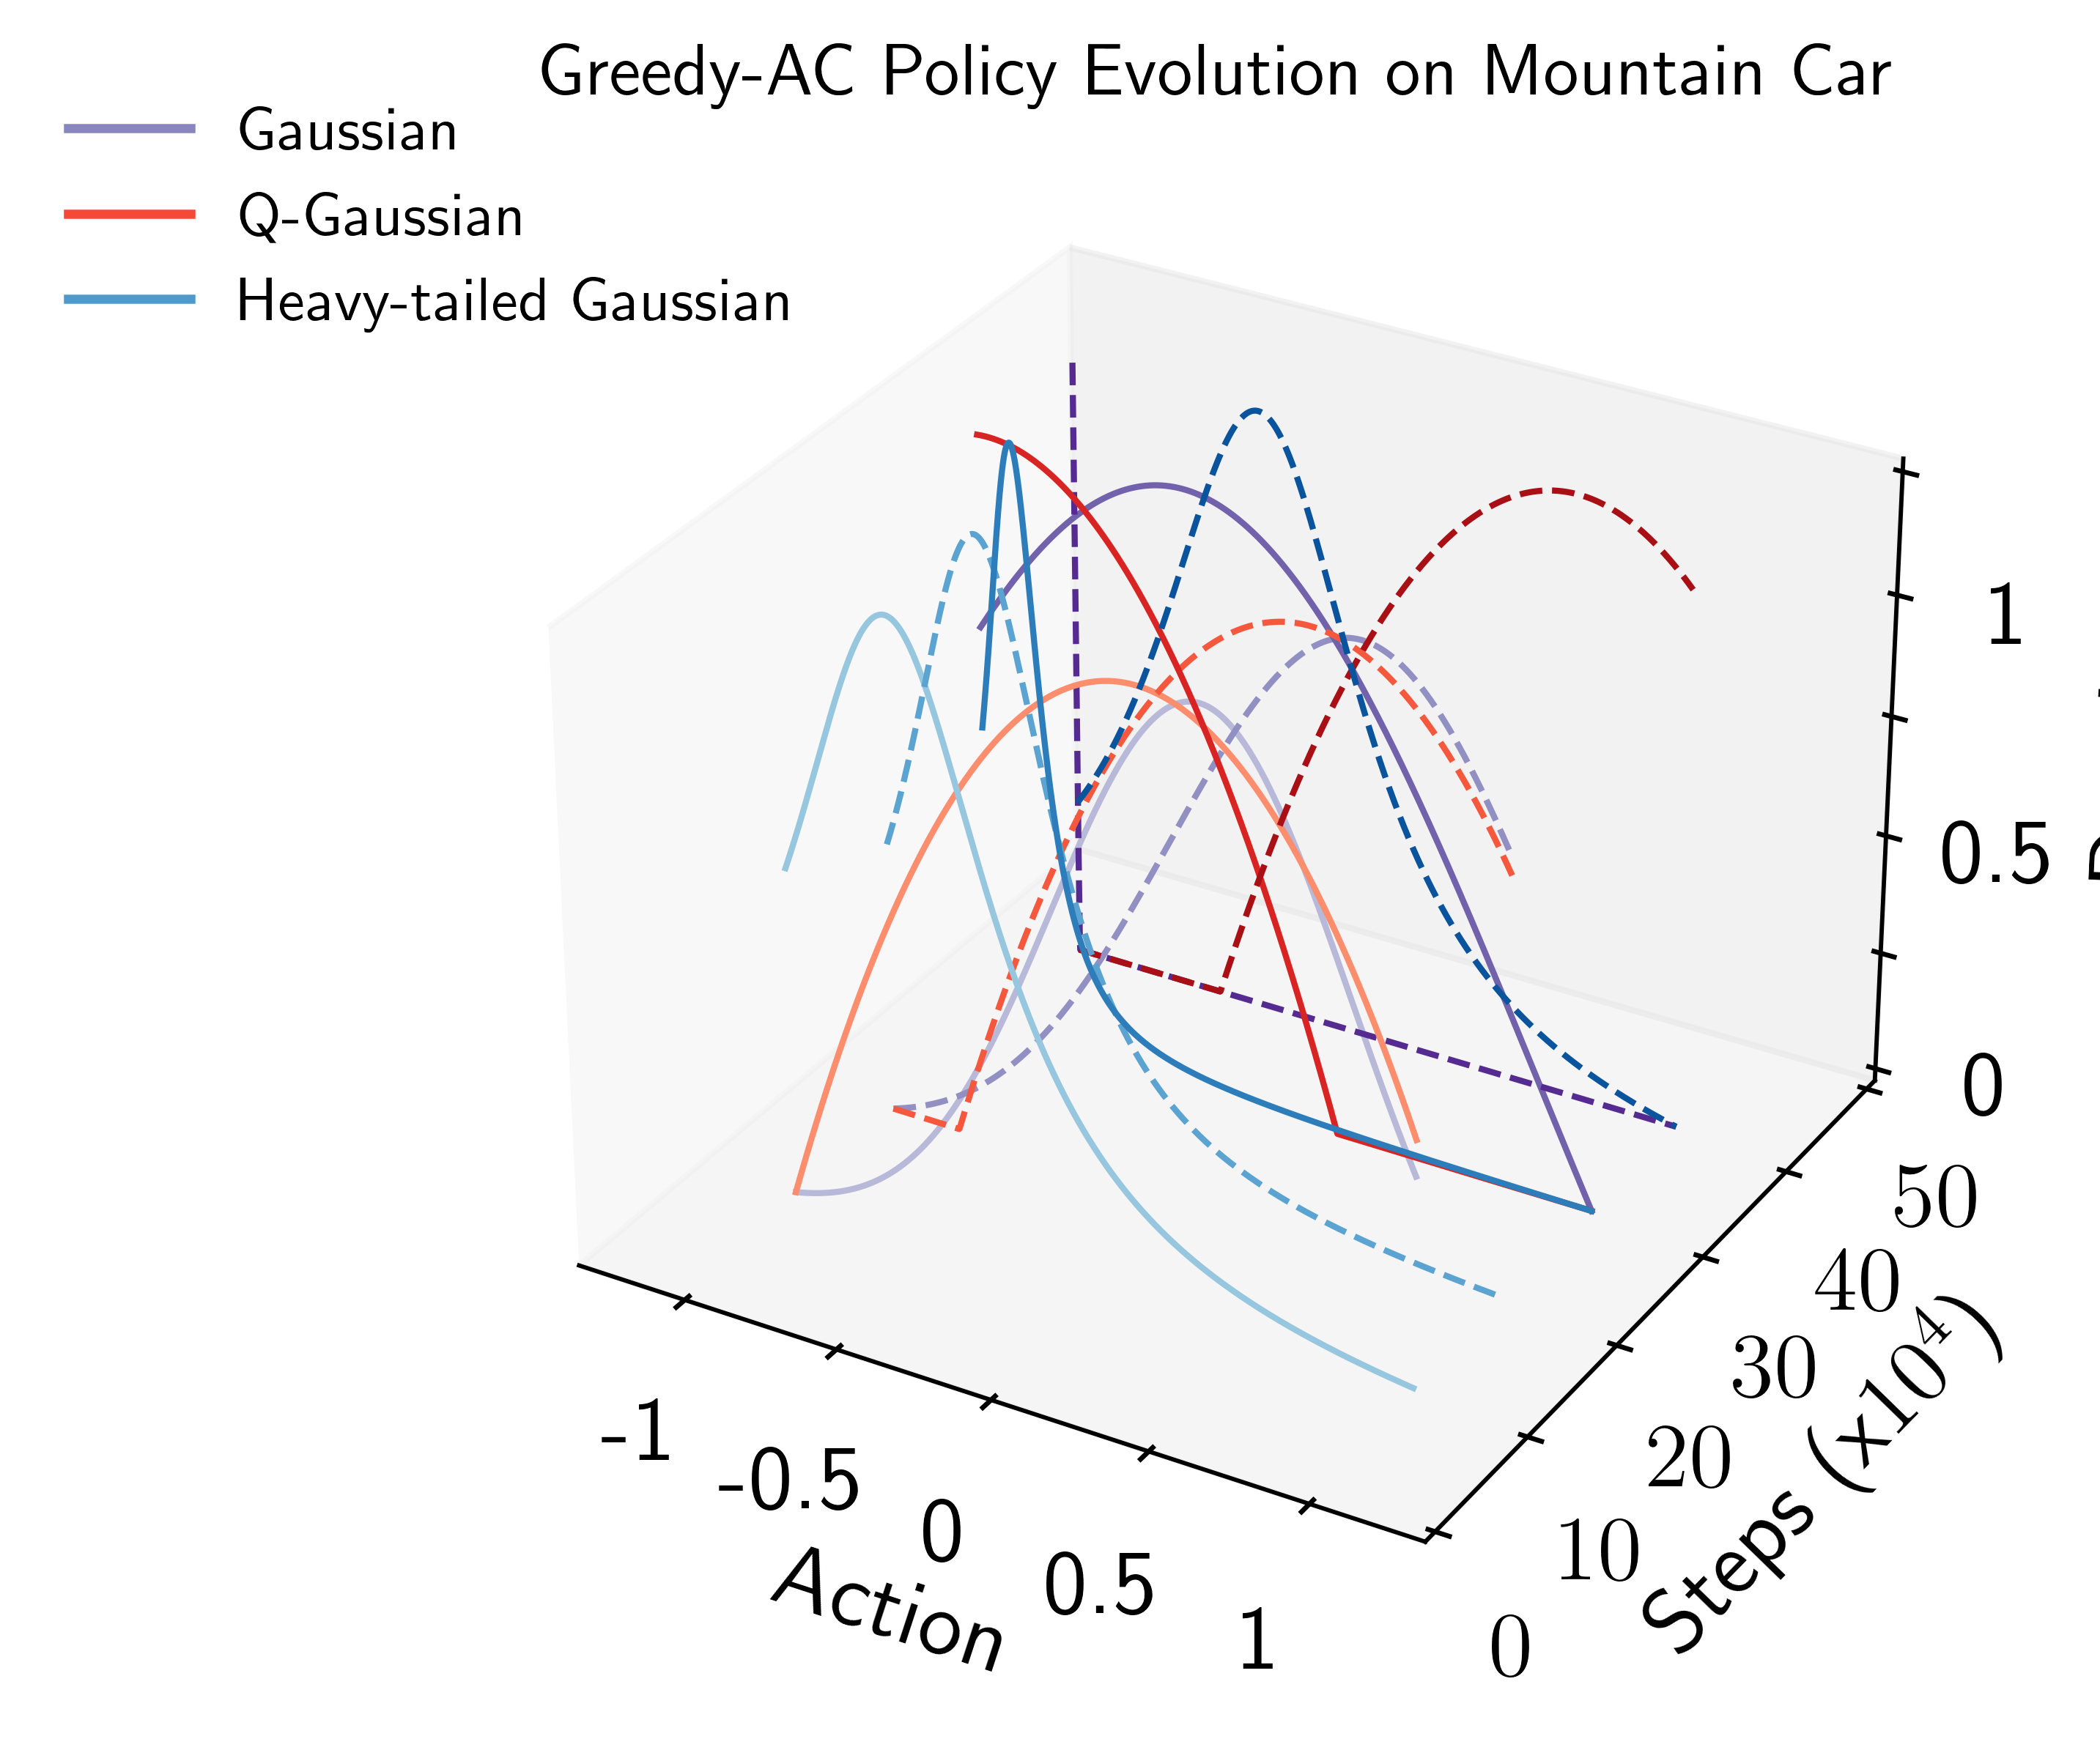

In [353]:
fig, ax = plt.subplots(1, 1, figsize=(7.2, 4.45), dpi=600, subplot_kw={'projection': '3d'})
plt.title("Greedy-AC Policy Evolution on Mountain Car", fontsize=12)

policy_evolution(torch.load('../saved_policies/gaussian.pt'), 2000, "Purples", fig, ax, "Gaussian")
policy_evolution(torch.load('../saved_policies/q_gaussian.pt'), 2000, "Reds", fig, ax, "Q-Gaussian")
policy_evolution(torch.load('../saved_policies/heavytailed_gaussian.pt'), 2000, "Blues", fig, ax, "Heavy-tailed Gaussian")

print('ax.azim {}'.format(ax.azim))
print('ax.elev {}'.format(ax.elev))

#ax.view_init(50, -25)
xticks = [-1, -0.5, 0, 0.5, 1]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=0)
#ax.set_zlim(-.3, 1.3)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(0, 50)
ax.grid(False)

#ax.set_zticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_zticklabels(['0', '', '0.5', '', '1'], rotation=0, ha='center')
ax.set_ylabel(r'Steps (x$10^4$)')
ax.set_zlabel(r'Density')
ax.set_xlabel(r'Action')
plt.legend(loc='lower left', bbox_to_anchor=(-0.3, 0.83), prop={'size': 10}, ncol=1, frameon=False)
plt.tight_layout()
plt.savefig("figures/policy_evolution_online1.png", dpi=600)
plt.savefig("figures/policy_evolution_online1.pdf", dpi=600)